Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Model: "Sequence-to-Sequence-Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input (InputLayer)  [(None, None, 71)]           0         []                            
                                                                                                  
 Decoder-Input (InputLayer)  [(None, None, 94)]           0         []                            
                                                                                                  
 Encoder-LSTM (LSTM)         [(None, 60),                 31680     ['Encoder-Input[0][0]']       
                              (None, 60),                                                         
       

C:\Users\jayanti.prasad\Anaconda3\envs\aiml_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 5s 64ms/step - loss: 0.1024 - accuracy: 0.6798 - val_loss: 0.0826 - val_accuracy: 0.6337
Epoch 3/100
80/80 [==============================] - 4s 55ms/step - loss: 0.0769 - accuracy: 0.6798 - val_loss: 0.0675 - val_accuracy: 0.6337
Epoch 4/100
80/80 [==============================] - 4s 55ms/step - loss: 0.0663 - accuracy: 0.6798 - val_loss: 0.0618 - val_accuracy: 0.6337
Epoch 5/100
80/80 [==============================] - 4s 55ms/step - loss: 0.0626 - accuracy: 0.6798 - val_loss: 0.0594 - val_accuracy: 0.6337
Epoch 6/100
80/80 [==============================] - 4s 55ms/step - loss: 0.0610 - accuracy: 0.6798 - val_loss: 0.0585 - val_accuracy: 0.6337
Epoch 7/100
80/80 [==============================] - 4s 55ms/step - loss: 0.0555 - accuracy: 0.6798 - val_loss: 0.0483 - val_accuracy: 0.6337
Epoch 8/100
80/80 [==============================] - 5s 63ms/step - loss: 0.0388 - accuracy: 0.6803 - val_loss: 0.0396 - val_accuracy: 0.6337
Epoch 9/100
80/80 

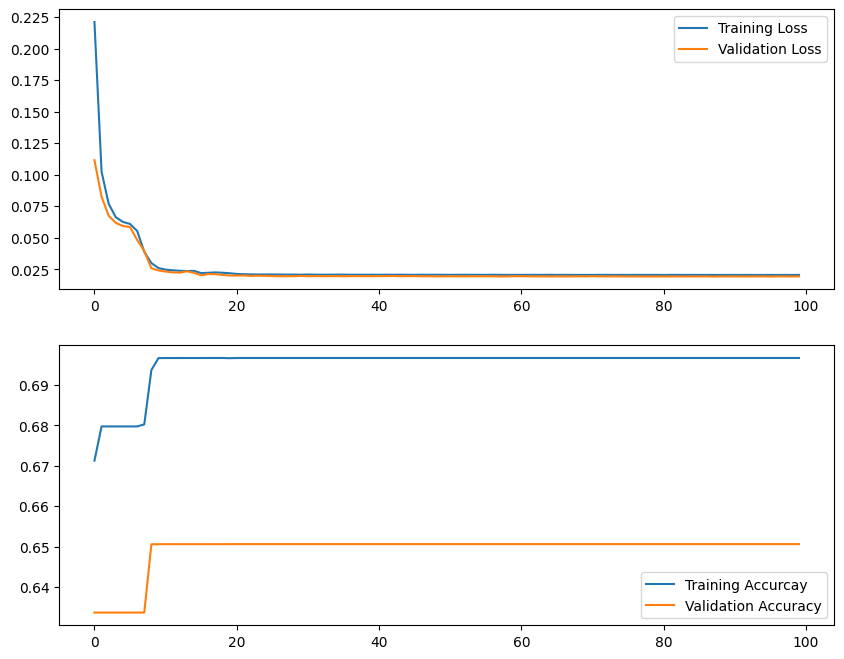

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras 
from keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint,  TensorBoard


class Seq2Seq_Train:
    def __init__(self, workspace_dir, df_config):
        
        self.workspace = workspace_dir 
        self.model_dir = self.workspace + os.sep + "trained_model"
        self.log_dir = self.workspace + os.sep + "log"

        if os.path.exists(self.log_dir) and os.path.isdir(self.log_dir):
            shutil.rmtree(self.log_dir)
        
        os.makedirs(self.workspace, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

        P = dict ( zip (df_config['key'].to_list(), df_config['value'].to_list()))

        self.num_encoder_tokens  = P['num_encoder_tokens']
        self.num_decoder_tokens = P['num_decoder_tokens'] 
        self.latent_dim = P['latent_dim'] 

        self.max_encoder_seq_length  = P['max_encoder_seq_length']
        self.max_decoder_seq_length  = P['max_decoder_seq_length'] 
        
        self.build_model()

    def build_model (self,):

       # Define an input sequence and process it.
       encoder_inputs = keras.Input(shape=(None, self.num_encoder_tokens),name='Encoder-Input')
       encoder = keras.layers.LSTM(self.latent_dim, return_state=True,name='Encoder-LSTM')
       encoder_outputs, state_h, state_c = encoder(encoder_inputs)

       # We discard `encoder_outputs` and only keep the states.
       encoder_states = [state_h, state_c]

       # Set up the decoder, using `encoder_states` as initial state.
       decoder_inputs = keras.Input(shape=(None, self.num_decoder_tokens),name='Decoder-Input')

       # We set up our decoder to return full output sequences,
       # and to return internal states as well. We don't use the
       # return states in the training model, but we will use them in inference.
       decoder_lstm = keras.layers.LSTM(self.latent_dim, return_sequences=True, return_state=True, name='Decoder-LSTM')
       decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
       decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation="softmax",name='Decoder-Dense')
       decoder_outputs = decoder_dense(decoder_outputs)

       # Define the model that will turn
       # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
       self.model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs,name='Sequence-to-Sequence-Model')


    def fit_model (self, input_texts, target_texts, input_token_index, target_token_index, epochs, batch_size):
        
        encoder_input_data = np.zeros((len(input_texts), self.max_encoder_seq_length, self.num_encoder_tokens), dtype="float32")
        decoder_input_data = np.zeros((len(input_texts), self.max_decoder_seq_length, self.num_decoder_tokens), dtype="float32" )
        decoder_target_data = np.zeros((len(input_texts), self.max_decoder_seq_length, self.num_decoder_tokens), dtype="float32")

        for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
            for t, char in enumerate(input_text):
                encoder_input_data[i, t, input_token_index[char]] = 1.0
                encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
            for t, char in enumerate(target_text):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, target_token_index[char]] = 1.0
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
                decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
                decoder_target_data[i, t:, target_token_index[" "]] = 1.0
        
        # Run training


        chkpt = ModelCheckpoint(filepath=self.model_dir + os.sep + "model.hdf5",
             save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

        tboard = TensorBoard(log_dir=self.log_dir)
        callbacks = [chkpt, tboard]

        optimizer = keras.optimizers.Adam(learning_rate=0.01)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
        history = self.model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs,  callbacks=callbacks,validation_split=0.2)
        return history 

def get_data():
     num_samples = 10000
     # Vectorize the data.
     data_path = r"C:\Users\jayanti.prasad\Data\NLP_DATA\seq2seq_data\fra.txt"
     input_texts = []
     target_texts = []
     input_characters = set()
     target_characters = set()

     with open(data_path, "r", encoding="utf-8") as f:
         lines = f.read().split("\n")

     for line in lines[: min(num_samples, len(lines) - 1)]:
         raw_line = line.split("\t")
         input_text, target_text = raw_line[0], raw_line[1] 
         # We use "tab" as the "start sequence" character
         # for the targets, and "\n" as "end sequence" character.
         target_text = "\t" + target_text + "\n"
         input_texts.append(input_text)
         target_texts.append(target_text)
         for char in input_text:
             if char not in input_characters:
                 input_characters.add(char)
         for char in target_text:
             if char not in target_characters:
                 target_characters.add(char)
     return input_texts, target_texts, input_characters, target_characters 


def get_params(input_texts, target_texts, input_characters, target_characters ):
    
     input_characters = sorted(list(input_characters))
     target_characters = sorted(list(target_characters))
     num_encoder_tokens = len(input_characters)
     num_decoder_tokens = len(target_characters)
     max_encoder_seq_length = max([len(txt) for txt in input_texts])
     max_decoder_seq_length = max([len(txt) for txt in target_texts])

     print("Number of samples:", len(input_texts))
     print("Number of unique input tokens:", num_encoder_tokens)
     print("Number of unique output tokens:", num_decoder_tokens)
     print("Max sequence length for inputs:", max_encoder_seq_length)
     print("Max sequence length for outputs:", max_decoder_seq_length)

     input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
     target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

     df_config = pd.DataFrame(columns=['key','value'])
     df_config['key'] = ['num_encoder_tokens',  'num_decoder_tokens', 'max_encoder_seq_length', 'max_decoder_seq_length']
     df_config['value'] = [num_encoder_tokens,  num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length] 

     df_inp_vocab = pd.DataFrame(columns=['token'])
     df_inp_vocab['token'] = list (input_token_index.keys()) 
   
     df_out_vocab = pd.DataFrame(columns=['token'])
     df_out_vocab['token'] = list (target_token_index.keys()) 

     return df_config, df_inp_vocab, df_out_vocab 


if __name__ == "__main__":

    workspace_dir = "tmp"  
    batch_size = 100  # Batch size for training.
    epochs = 100  # Number of epochs to train for.
    latent_dim = 60  # Latent dimensionality of the encoding space.

    input_texts, target_texts, input_characters, target_characters  = get_data () 
     
    
    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
    
    df_config, df_inp_vocab, df_out_vocab = get_params(input_texts, target_texts, input_characters, target_characters )
    df_config.loc[len(df_config)] = ['latent_dim',latent_dim] 
    
    df_inp_vocab.to_csv (workspace_dir + os.sep + "vocab_in.csv")
    df_out_vocab.to_csv (workspace_dir + os.sep + "vocab_out.csv")
    df_config.to_csv (workspace_dir + os.sep + "params.csv")

    M = Seq2Seq_Train (workspace_dir, df_config)
    print(M.model.summary())

    hist = M.fit_model (input_texts, target_texts, input_token_index, target_token_index, epochs, batch_size)

    fig, axs  = plt.subplots (2,1,figsize=(10,8))
    axs[0].plot(hist.history['loss'],label='Training Loss')
    axs[0].plot(hist.history['val_loss'],label='Validation Loss')
    axs[1].plot(hist.history['accuracy'],label='Training Accurcay')
    axs[1].plot(hist.history['val_accuracy'],label='Validation Accuracy')
    axs[0].legend()
    axs[1].legend()
    plt.show()